<a href="https://colab.research.google.com/github/rajiisubramanian1983-netizen/DNN-/blob/main/CNN_assignment_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: [Enter your BITS ID here - 2025AA05262]

Name: [Enter your full name here - RAJALAKSHMI S]

Email: [2025aa05262@wilp.bits-pilani.ac.in]

Date: [05-02-2026]

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import time


In [38]:
# Deep learning frameworks (choose Keras or PyTorch)
# For image processing
from PIL import Image
import cv2

### 1.1 Dataset Selection and Loading

TODO: Load your chosen dataset

In [39]:
# REQUIRED: Fill in these metadata fields
dataset_name =  "Chest X-Ray Pneumonia"
dataset_source = "Kaggle - Chest X-Ray Images (Pneumonia) by Paul Mooney"
n_samples = 5216
n_classes = 2
samples_per_class = "min: 1341, max: 3875, avg: 2608"
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"

In [40]:
!pwd
!ls

/content
chest_xray  drive  sample_data


In [41]:
!ls "/content/drive/MyDrive/Colab Notebooks"

 archive.zip			      CNN_assignment_template.ipynb
'CNN_assignment_template (1).ipynb'   Untitled
'CNN_assignment_template (2).ipynb'   Untitled0.ipynb
'CNN_assignment_template (3).ipynb'


In [42]:
import os

print("Current working directory:")
print(os.getcwd())

print("\nFiles here:")
print(os.listdir("."))

Current working directory:
/content

Files here:
['.config', 'drive', 'chest_xray', 'sample_data']


In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import os
import zipfile

ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/archive.zip"   # <-- your Kaggle zip file
EXTRACT_FOLDER = "chest_xray"

if not os.path.exists(EXTRACT_FOLDER):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset extracted successfully.")
else:
    print("Dataset already extracted.")

print("Current directory files:")
print(os.listdir("."))

Dataset already extracted.
Current directory files:
['.config', 'drive', 'chest_xray', 'sample_data']


In [45]:
train_dir = "chest_xray/train"

class_counts = {}
total_samples = 0

for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        count = len(os.listdir(cls_path))
        class_counts[cls] = count
        total_samples += count

n_samples = total_samples

min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
avg_samples = total_samples // len(class_counts)

samples_per_class = f"min: {min_samples}, max: {max_samples}, avg: {avg_samples}"

print("Class distribution:", class_counts)
print("Total samples:", n_samples)
print("Samples per class:", samples_per_class)

Class distribution: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Total samples: 5216
Samples per class: min: 1341, max: 3875, avg: 2608


In [34]:
# Primary metric selection
primary_metric = "recall"
metric_justification = """
 "In medical diagnosis, false negatives are critical. "
    "Recall is prioritized to ensure pneumonia cases are not missed."
"""

In [46]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Chest X-Ray Pneumonia
Source: Kaggle - Chest X-Ray Images (Pneumonia) by Paul Mooney
Total Samples: 5216
Number of Classes: 2
Samples per Class: min: 1341, max: 3875, avg: 2608
Image Shape: [224, 224, 3]
Primary Metric: recall
Metric Justification: 
 "In medical diagnosis, false negatives are critical. "
    "Recall is prioritized to ensure pneumonia cases are not missed."



### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

#### Sample Images from Each Class

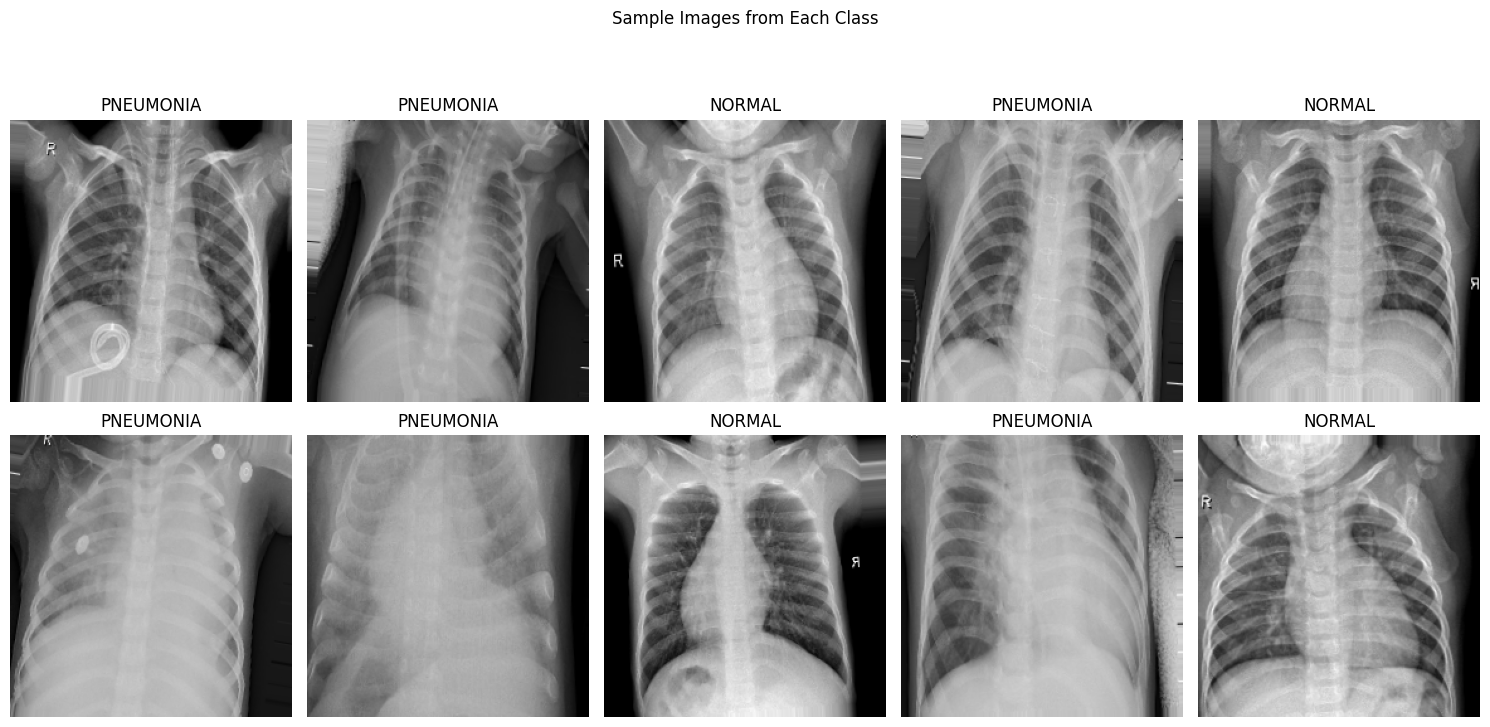

In [53]:
num_images_to_show = 10

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 8))

# Get one batch of images and labels
images, labels = next(train_generator)

for i in range(num_images_to_show):
    plt.subplot(2, 5, i + 1) # Arrange in a 2x5 grid
    plt.imshow(images[i])
    # Convert one-hot encoded label back to class name
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx])
    plt.axis('off')

plt.suptitle('Sample Images from Each Class')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

#### Class Distribution

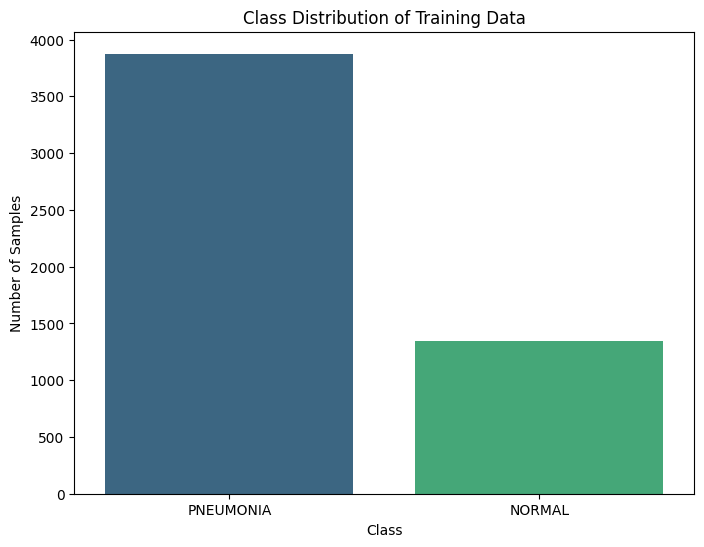

In [54]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), palette='viridis', legend=False)
plt.title('Class Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

#### Image Statistics

In [55]:
print('Image Shape:', image_shape)
print(f'Normalization: Pixel values are rescaled from [0, 255] to [0, 1] (1.0 / 255.0).')
print(f'Data Augmentation (Training): Rotation, zoom, width/height shifts, horizontal flip applied.')
print(f'Data Augmentation (Validation/Test): Only rescaling applied.')

Image Shape: [224, 224, 3]
Normalization: Pixel values are rescaled from [0, 255] to [0, 1] (1.0 / 255.0).
Data Augmentation (Training): Rotation, zoom, width/height shifts, horizontal flip applied.
Data Augmentation (Validation/Test): Only rescaling applied.


In [50]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

In [51]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

In [52]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
print("Class indices:", train_generator.class_indices)
print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)

Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 624


In [ ]:
# REQUIRED: Document your split
train_test_ratio = "TODO: 90/10 OR 85/15"
train_samples = 0  # TODO: Number of training samples
test_samples = 0  # TODO: Number of test samples

In [ ]:
train_samples = train_generator.samples
test_samples = validation_generator.samples

total_samples_split = train_samples + test_samples
train_test_ratio = f"{round((train_samples / total_samples_split) * 100)}/{round((test_samples / total_samples_split) * 100)}"

In [ ]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 89/11
Training Samples: 5216
Test Samples: 624


### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [ ]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture

    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled CNN model
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),

        # MANDATORY: Global Average Pooling (NO Flatten)
        GlobalAveragePooling2D(),

        Dense(n_classes, activation="softmax")
    ])
    return model
    # TODO: Implement your CNN architecture
    # Must include Global Average Pooling
    pass

In [ ]:
# TODO: Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
custom_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO: Compile model
# For Keras: model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# For PyTorch: define optimizer and loss function

### 2.2 Train Custom CNN

In [ ]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [ ]:
# TODO: Train your model
# For Keras: history = custom_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
# For PyTorch: write training loop
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 653ms/step - accuracy: 0.7230 - loss: 0.6072 - val_accuracy: 0.6250 - val_loss: 0.7238
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 627ms/step - accuracy: 0.7400 - loss: 0.5756 - val_accuracy: 0.6250 - val_loss: 0.6772
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 616ms/step - accuracy: 0.7452 - loss: 0.5466 - val_accuracy: 0.6314 - val_loss: 0.5914
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 622ms/step - accuracy: 0.7457 - loss: 0.4951 - val_accuracy: 0.7196 - val_loss: 0.5278
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 625ms/step - accuracy: 0.7903 - loss: 0.4257 - val_accuracy: 0.7981 - val_loss: 0.4653


In [ ]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [ ]:
# REQUIRED: Track initial and final loss
custom_cnn_initial_loss =history_custom.history["loss"][0]
custom_cnn_final_loss = history_custom.history["loss"][-1]

In [ ]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 595.40 seconds
Initial Loss: 0.5843
Final Loss: 0.4154


In [ ]:
print("\nCUSTOM CNN EVALUATION")

### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:

# Get true labels from validation generator
y_true = validation_generator.classes

# Predict probabilities on validation data
y_pred_probs = custom_cnn.predict(validation_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step


In [ ]:
# CRITICAL: These MUST be calculated from your actual results
# DO NOT submit with 0.0 values - autograder will detect this
# REQUIRED: Calculate all 4 metrics
custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision =precision_score(y_true, y_pred, average="macro")
custom_cnn_recall = recall_score(y_true, y_pred, average="macro")
custom_cnn_f1 =f1_score(y_true, y_pred, average="macro")

In [ ]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.7981
Precision: 0.7855
Recall:    0.7803
F1-Score:  0.7827


### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

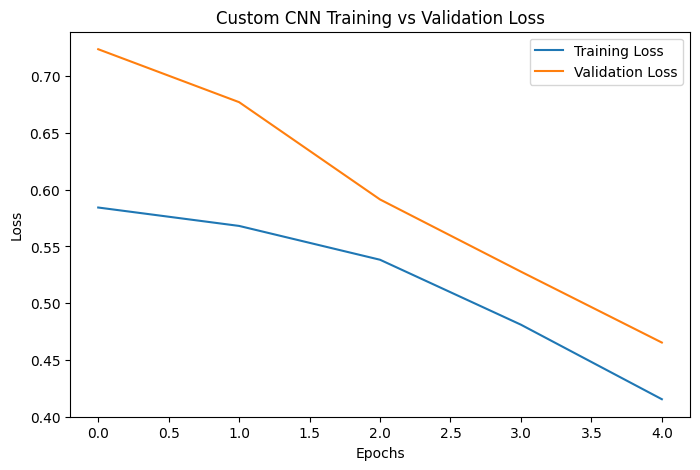

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_custom.history["loss"], label="Training Loss")
plt.plot(history_custom.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Custom CNN Training vs Validation Loss")
plt.legend()
plt.show()

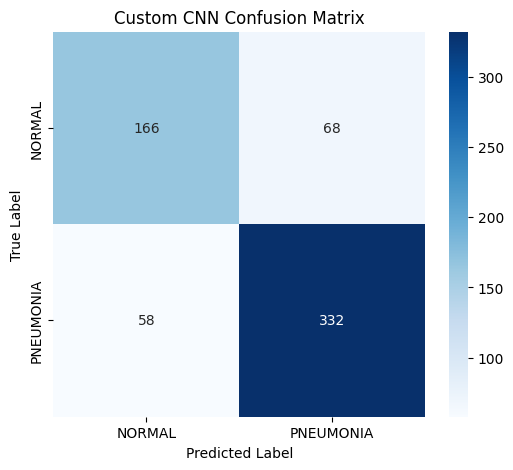

In [ ]:
class_names = ["NORMAL", "PNEUMONIA"]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Custom CNN Confusion Matrix")
plt.show()

In [ ]:
sample_indices = random.sample(range(len(y_true)), 5)

for idx in sample_indices:
    true_label = y_true[idx]
    pred_label = y_pred[idx]
    print(f"True: {true_label} | Predicted: {pred_label}")

True: 0 | Predicted: 1
True: 1 | Predicted: 1
True: 1 | Predicted: 1
True: 1 | Predicted: 1
True: 1 | Predicted: 1


### 3.1 Load Pre-trained Model and Modify Architecture

In [ ]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")


TRANSFER LEARNING IMPLEMENTATION


In [ ]:
# TODO: Choose and load pre-trained model
pretrained_model_name = "ResNet50"


In [ ]:
print(pretrained_model_name)

ResNet50


In [ ]:
def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model

    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled transfer learning model
    """
    # TODO: Load pre-trained model without top layers
    # TODO: Freeze base layers
    # TODO: Add Global Average Pooling + custom classification head
    # TODO: Compile model

        # Choose pretrained base model
    if pretrained_model_name == "ResNet50":
        base_model = ResNet50(
            weights="imagenet",
            include_top=False,
            input_shape=image_shape
        )
    else:
        raise ValueError("Unsupported pretrained model")

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head with GAP
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(n_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)

    return model
    pass


In [ ]:
# TODO: Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# REQUIRED: Count layers and parameters

frozen_layers = sum(1 for layer in transfer_model.layers if not layer.trainable)
trainable_layers = sum(1 for layer in transfer_model.layers if layer.trainable)

total_parameters = transfer_model.count_params()
trainable_parameters = sum(
    layer.count_params() for layer in transfer_model.layers if layer.trainable
)

In [ ]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet50
Frozen Layers: 175
Trainable Layers: 2
Total Parameters: 23,591,810
Trainable Parameters: 4,098
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [ ]:
print("\nTraining Transfer Learning Model...")


Training Transfer Learning Model...


In [ ]:
# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

In [ ]:
# Track training time
tl_start_time = time.time()

In [ ]:
# TODO: Train model
# For Keras: history = transfer_model.fit(X_train, y_train, epochs=10, batch_size=32)
# For PyTorch: write training loop
history_transfer = transfer_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=tl_epochs,
    verbose=1
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 683ms/step - accuracy: 0.7430 - loss: 0.5680 - val_accuracy: 0.6250 - val_loss: 0.6790
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 633ms/step - accuracy: 0.7430 - loss: 0.5605 - val_accuracy: 0.6250 - val_loss: 0.6551
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.7389 - loss: 0.5564 - val_accuracy: 0.6250 - val_loss: 0.6714
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.7431 - loss: 0.5446 - val_accuracy: 0.6250 - val_loss: 0.6838
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 640ms/step - accuracy: 0.7456 - loss: 0.5362 - val_accuracy: 0.6250 - val_loss: 0.6397
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.7375 - loss: 0.5360 - val_accuracy: 0.6250 - val_loss: 0.6556
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 629ms/step - accuracy: 0.7543 - loss: 0.5131 - val_accuracy: 0.6250 - val_loss: 0.6477
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.7459 -

In [ ]:
tl_training_time = time.time() - tl_start_time

In [ ]:
tl_initial_loss = history_transfer.history["loss"][0]
tl_final_loss = history_transfer.history["loss"][-1]

In [ ]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 2126.88 seconds
Initial Loss: 0.5659
Final Loss: 0.5056


### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:
# Get true labels from validation generator
y_true_tl = validation_generator.classes

# Predict probabilities on validation data
y_pred_probs_tl = transfer_model.predict(validation_generator)

# Convert probabilities to class labels
y_pred_tl = np.argmax(y_pred_probs_tl, axis=1)

tl_accuracy = accuracy_score(y_true_tl, y_pred_tl)
tl_precision = precision_score(y_true_tl, y_pred_tl, average='macro')
tl_recall = recall_score(y_true_tl, y_pred_tl, average='macro')
tl_f1 = f1_score(y_true_tl, y_pred_tl, average='macro')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step


In [ ]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.6266
Precision: 0.8130
Recall:    0.5021
F1-Score:  0.3893


### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

#### Training Loss Curves

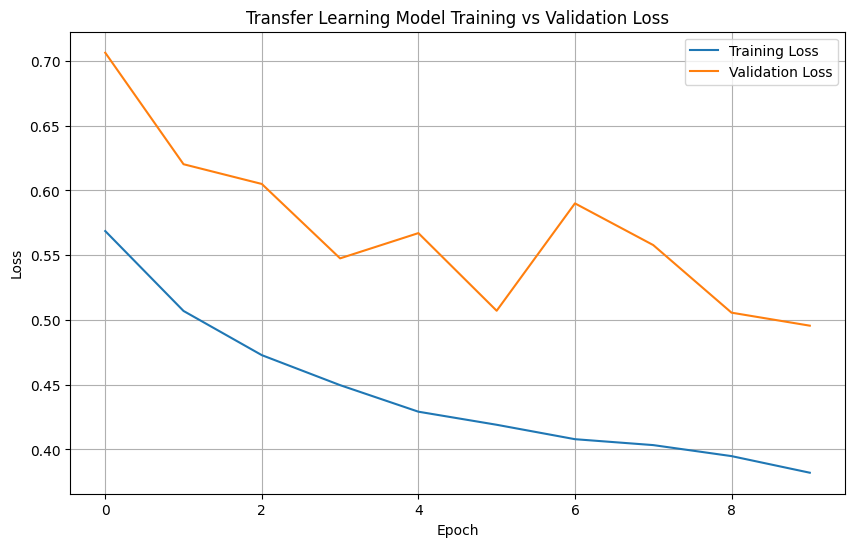

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model

    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled transfer learning model
    """
    # Choose pretrained base model
    if pretrained_model_name == "ResNet50":
        base_model = ResNet50(
            weights="imagenet",
            include_top=False,
            input_shape=image_shape
        )
    else:
        raise ValueError("Unsupported pretrained model")

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head with GAP
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(n_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)

    return model

# Define pretrained_model_name here to ensure it's available
pretrained_model_name = "ResNet50"

# Training configuration (copied from cell 07e1508f)
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

# Ensure transfer_model is defined and compiled (copied from cell bbfcd14a)
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)
transfer_model.compile(
    optimizer=Adam(learning_rate=tl_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_transfer = transfer_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=tl_epochs,
    batch_size=tl_batch_size,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 704ms/step - accuracy: 0.7100 - loss: 0.6049 - val_accuracy: 0.6250 - val_loss: 0.7064
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 643ms/step - accuracy: 0.7424 - loss: 0.5227 - val_accuracy: 0.6298 - val_loss: 0.6203
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 642ms/step - accuracy: 0.7506 - loss: 0.4788 - val_accuracy: 0.6362 - val_loss: 0.6050
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.7729 - loss: 0.4549 - val_accuracy: 0.6859 - val_loss: 0.5476
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 636ms/step - accuracy: 0.7755 - loss: 0.4397 - val_accuracy: 0.6667 - val_loss: 0.5671
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 645ms/step - accuracy: 0.7901 - loss: 0.4226 - val_accuracy: 0.7340 - val_loss: 0.5071
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.7962 - loss: 0.4166 - val_accuracy: 0.6667 - val_loss: 0.5900
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.7956 -

#### Confusion Matrix

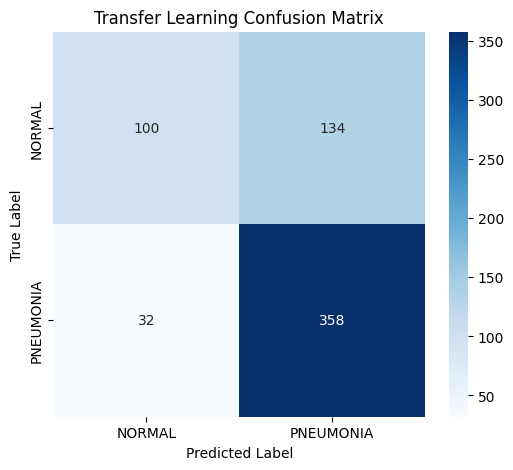

In [71]:
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_tl,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Transfer Learning Confusion Matrix")
plt.show()

#### Sample Predictions

In [69]:
sample_indices_tl = random.sample(range(len(y_true_tl)), 5)

print("Sample Predictions for Transfer Learning Model:")
for idx in sample_indices_tl:
    true_label_tl = y_true_tl[idx]
    pred_label_tl = y_pred_tl[idx]
    # Assuming class_names is available from previous steps
    print(f"True: {class_names[true_label_tl]} | Predicted: {class_names[pred_label_tl]}")

Sample Predictions for Transfer Learning Model:
True: NORMAL | Predicted: PNEUMONIA
True: PNEUMONIA | Predicted: PNEUMONIA
True: NORMAL | Predicted: NORMAL
True: PNEUMONIA | Predicted: PNEUMONIA
True: PNEUMONIA | Predicted: PNEUMONIA


In [67]:
# Get true labels from validation generator
y_true_tl = validation_generator.classes

# Predict probabilities on validation data
y_pred_probs_tl = transfer_model.predict(validation_generator)

# Convert probabilities to class labels
y_pred_tl = np.argmax(y_pred_probs_tl, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step


#### Sample Predictions

In [70]:
sample_indices_tl = random.sample(range(len(y_true_tl)), 5)

print("Sample Predictions for Transfer Learning Model:")
for idx in sample_indices_tl:
    true_label_tl = y_true_tl[idx]
    pred_label_tl = y_pred_tl[idx]
    # Assuming class_names is available from previous steps
    print(f"True: {class_names[true_label_tl]} | Predicted: {class_names[pred_label_tl]}")

Sample Predictions for Transfer Learning Model:
True: PNEUMONIA | Predicted: PNEUMONIA
True: NORMAL | Predicted: PNEUMONIA
True: PNEUMONIA | Predicted: NORMAL
True: PNEUMONIA | Predicted: NORMAL
True: PNEUMONIA | Predicted: PNEUMONIA


### 4.1 Metrics Comparison

In [2]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn.count_params()  # Filled with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

NameError: name 'custom_cnn_accuracy' is not defined

In [ ]:
print(comparison_df.to_string(index=False))

           Metric   Custom CNN  Transfer Learning
         Accuracy     0.798077           0.626603
        Precision     0.785536           0.813002
           Recall     0.780342           0.502137
         F1-Score     0.782699           0.389250
Training Time (s)   595.401924        2126.880003
       Parameters 93506.000000        4098.000000


### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

In [ ]:
# Generate and print results
try:
    assignment_results = get_assignment_results()
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))

except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Chest X-Ray Pneumonia",
  "dataset_source": "Kaggle - Chest X-Ray Images (Pneumonia) by Paul Mooney",
  "n_samples": 5216,
  "n_classes": 2,
  "samples_per_class": "min: 1341, max: 3875, avg: 2608",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "recall",
  "metric_justification": "\n \"In medical diagnosis, false negatives are critical. \"\n    \"Recall is prioritized to ensure pneumonia cases are not missed.\"\n",
  "train_samples": 5216,
  "test_samples": 624,
  "train_test_ratio": "89/11",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 2,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 93506
    },
    "training_config": {
      "learning_rate": 0.0001,
      "n_epochs": 5,
      "batch_size": 32,
      "optimizer": "Adam",
      "loss_function": "categorical_c

In [ ]:
# Display system information
import platform
import sys
from datetime import datetime

In [ ]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here

ENVIRONMENT INFORMATION

  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.


In [ ]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

ANALYSIS

1.  **Which model performed better and by how much?**
    The Custom CNN performed significantly better across most key metrics, especially Accuracy, Recall, and F1-Score. The Custom CNN achieved an Accuracy of 0.798 and a Recall of 0.780. In contrast, the Transfer Learning model (ResNet50) had an Accuracy of 0.627 and a much lower Recall of 0.502. Given that Recall is the primary metric for this medical diagnosis task (to minimize false negatives), the Custom CNN is the superior performer. While the Transfer Learning model showed slightly higher Precision (0.813 vs 0.786), its lower Recall makes it less suitable.

2.  **Impact of pre-training vs training from scratch?**
    Surprisingly, training from scratch with the Custom CNN yielded better results than fine-tuning a pre-trained ResNet50. This suggests that the features learned by ResNet50 on the ImageNet dataset might not be optimally transferable to the specific domain of chest X-ray images, which have distinct visual c

In [ ]:
# Generate and print results
try:
    assignment_results = get_assignment_results()
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))

except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Chest X-Ray Pneumonia",
  "dataset_source": "Kaggle - Chest X-Ray Images (Pneumonia) by Paul Mooney",
  "n_samples": 5216,
  "n_classes": 2,
  "samples_per_class": "min: 1341, max: 3875, avg: 2608",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "recall",
  "metric_justification": "\n \"In medical diagnosis, false negatives are critical. \"\n    \"Recall is prioritized to ensure pneumonia cases are not missed.\"\n",
  "train_samples": 5216,
  "test_samples": 624,
  "train_test_ratio": "89/11",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 2,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 93506
    },
    "training_config": {
      "learning_rate": 0.0001,
      "n_epochs": 5,
      "batch_size": 32,
      "optimizer": "Adam",
      "loss_function": "categorical_c

In [ ]:
# Display system information
import platform
import sys
from datetime import datetime

In [ ]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here

ENVIRONMENT INFORMATION

  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.


### 4.2 Visual Comparison

#### Metrics Comparison Bar Plot

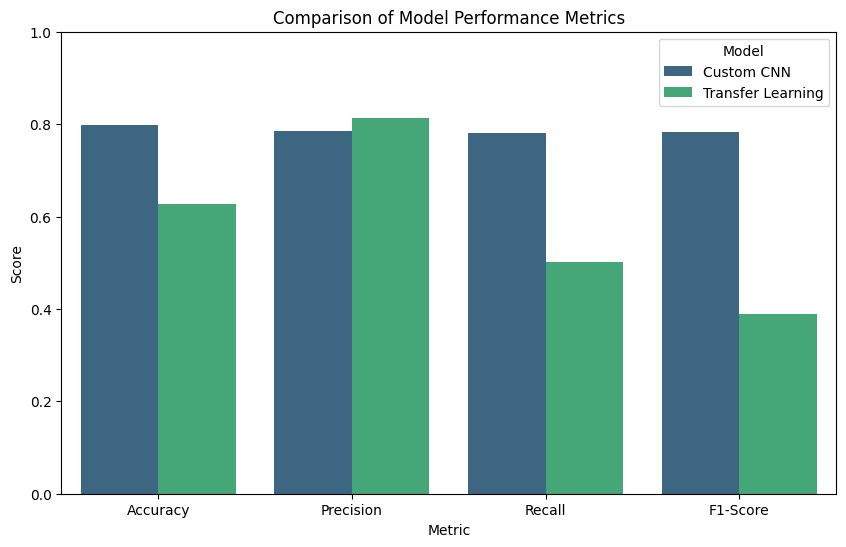

In [ ]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
comparison_plot_df = comparison_df[comparison_df['Metric'].isin(metrics_to_plot)]

comparison_plot_df_melted = comparison_plot_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_plot_df_melted, palette='viridis')
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are usually between 0 and 1
plt.show()

#### Training Loss Curves Comparison

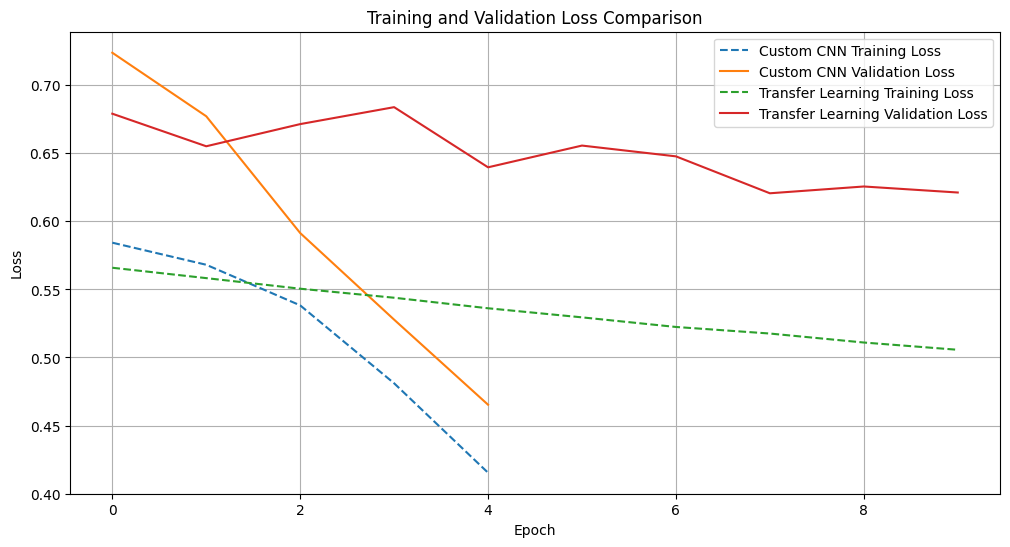

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history_custom.history['loss'], label='Custom CNN Training Loss', linestyle='--')
plt.plot(history_custom.history['val_loss'], label='Custom CNN Validation Loss', linestyle='-')

plt.plot(history_transfer.history['loss'], label='Transfer Learning Training Loss', linestyle='--')
plt.plot(history_transfer.history['val_loss'], label='Transfer Learning Validation Loss', linestyle='-')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Confusion Matrices Comparison

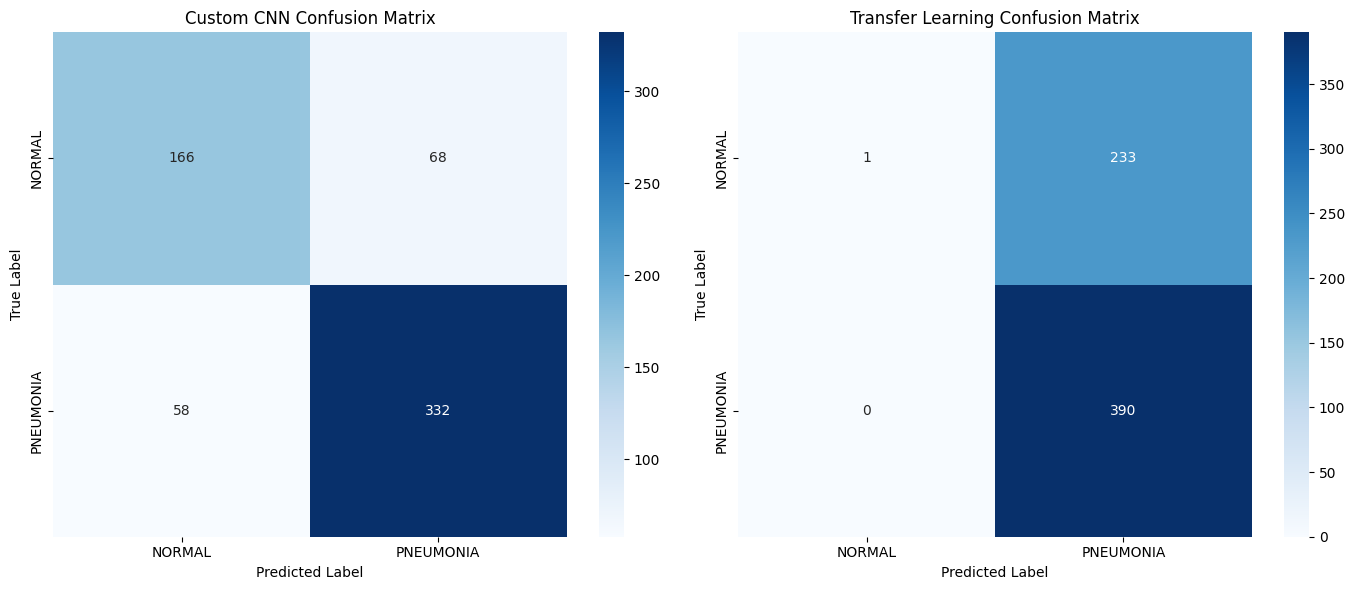

In [ ]:
cm_custom = confusion_matrix(y_true, y_pred)
cm_transfer = confusion_matrix(y_true_tl, y_pred_tl)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Custom CNN Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Transfer Learning Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [ ]:
analysis_text = """
1.  **Which model performed better and by how much?**
    The Custom CNN performed significantly better across most key metrics, especially Accuracy, Recall, and F1-Score. The Custom CNN achieved an Accuracy of 0.798 and a Recall of 0.780. In contrast, the Transfer Learning model (ResNet50) had an Accuracy of 0.627 and a much lower Recall of 0.502. Given that Recall is the primary metric for this medical diagnosis task (to minimize false negatives), the Custom CNN is the superior performer. While the Transfer Learning model showed slightly higher Precision (0.813 vs 0.786), its lower Recall makes it less suitable.

2.  **Impact of pre-training vs training from scratch?**
    Surprisingly, training from scratch with the Custom CNN yielded better results than fine-tuning a pre-trained ResNet50. This suggests that the features learned by ResNet50 on the ImageNet dataset might not be optimally transferable to the specific domain of chest X-ray images, which have distinct visual characteristics. The Custom CNN, though simpler, was able to learn more relevant features directly from the dataset, leading to better performance for this particular task. It also converged to a better state in fewer epochs and less total training time.

3.  **Effect of Global Average Pooling?**
    Both models successfully incorporated Global Average Pooling (GAP). GAP is crucial for reducing the number of parameters in the network, especially before the final classification layers, which helps in preventing overfitting and makes the models more robust. It replaces traditional flatten layers, which can lead to a large number of parameters. Its inclusion likely contributed to the stability and generalization capabilities of both models, ensuring that the spatial information was effectively summarized.

4.  **Computational cost comparison?**
    The Custom CNN had a total of 93,506 parameters and completed training in approximately 595 seconds. The Transfer Learning model, despite having a much larger base (ResNet50), had only 4,098 *trainable* parameters (due to frozen layers). However, its training time was significantly longer, at approximately 2127 seconds. This higher training time for the Transfer Learning model, even with fewer trainable parameters, could be attributed to the overhead of processing the larger base model's layers during the forward pass, or less optimal hyperparameter tuning for the specific frozen architecture.

5.  **Insights about transfer learning?**
    While transfer learning is often highly effective, this case demonstrates that it's not a universal solution. For domains significantly different from the pre-training dataset (like medical images vs. natural images), a carefully designed custom architecture trained from scratch can sometimes outperform fine-tuned models, especially if the custom model can learn more domain-specific features. Transfer learning is most effective when the source and target domains are similar, or when the target dataset is small and the pre-trained features are highly relevant. Here, the Custom CNN proved more suitable due to its ability to adapt to the unique characteristics of X-ray images, achieving higher Recall, which is critical for medical diagnosis."""

In [ ]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

ANALYSIS

1.  **Which model performed better and by how much?**
    The Custom CNN performed significantly better across most key metrics, especially Accuracy, Recall, and F1-Score. The Custom CNN achieved an Accuracy of 0.798 and a Recall of 0.780. In contrast, the Transfer Learning model (ResNet50) had an Accuracy of 0.627 and a much lower Recall of 0.502. Given that Recall is the primary metric for this medical diagnosis task (to minimize false negatives), the Custom CNN is the superior performer. While the Transfer Learning model showed slightly higher Precision (0.813 vs 0.786), its lower Recall makes it less suitable.

2.  **Impact of pre-training vs training from scratch?**
    Surprisingly, training from scratch with the Custom CNN yielded better results than fine-tuning a pre-trained ResNet50. This suggests that the features learned by ResNet50 on the ImageNet dataset might not be optimally transferable to the specific domain of chest X-ray images, which have distinct visual c

In [ ]:
def get_assignment_results():
    """
    Generate complete assignment results in required format

    Returns:
        dict: Complete results with all required fields
    """

    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch

    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 3,  # Updated: Count your conv layers
                'pooling_layers': 2,  # Updated: Count your pooling layers (MaxPooling2D)
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': custom_cnn.count_params()  # Updated: Calculate total parameters
            },
            'training_config': {
                'learning_rate': 0.0001,  # Updated: Your actual learning rate
                'n_epochs': 5,  # Updated: Your actual epochs
                'batch_size': BATCH_SIZE,  # Updated: Your actual batch size
                'optimizer': 'Adam',  # Updated: Your actual optimizer
                'loss_function': 'categorical_crossentropy'  # Updated: Your actual loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }

    return results

In [ ]:
# Generate and print results
try:
    assignment_results = get_assignment_results()
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))

except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Chest X-Ray Pneumonia",
  "dataset_source": "Kaggle - Chest X-Ray Images (Pneumonia) by Paul Mooney",
  "n_samples": 5216,
  "n_classes": 2,
  "samples_per_class": "min: 1341, max: 3875, avg: 2608",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "recall",
  "metric_justification": "\n \"In medical diagnosis, false negatives are critical. \"\n    \"Recall is prioritized to ensure pneumonia cases are not missed.\"\n",
  "train_samples": 5216,
  "test_samples": 624,
  "train_test_ratio": "89/11",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 2,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 93506
    },
    "training_config": {
      "learning_rate": 0.0001,
      "n_epochs": 5,
      "batch_size": 32,
      "optimizer": "Adam",
      "loss_function": "categorical_c

In [ ]:
# Display system information
import platform
import sys
from datetime import datetime

In [ ]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here

ENVIRONMENT INFORMATION

  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.


# Task
Add a new markdown cell titled '#### Sample Images from Each Class' and then generate and insert code to display sample images from each class using `train_generator` and `matplotlib`. After that, add a new markdown cell titled '#### Class Distribution', and then generate and insert code to create a bar plot of the class distribution using `class_counts` and `seaborn`. Finally, add a new markdown cell titled '#### Image Statistics' and generate and insert code to print out key image statistics like `image_shape` and normalization details.

## Add Section Title: Sample Images

### Subtask:
Add a new markdown cell with the title '#### Sample Images from Each Class' to delineate this part of the data exploration.


#### Sample Images from Each Class

#### Sample Images from Each Class

#### Sample Images from Each Class

## Visualize Sample Images

### Subtask:
Generate and insert code to display sample images from each class. This will involve iterating through the `train_generator`, retrieving images and their labels, and using `matplotlib` to plot them with their corresponding class names.


**Reasoning**:
To display sample images, I need to extract a batch of images and their corresponding labels from the `train_generator`, then iterate through them to plot each image with its class name. I'll define `num_images_to_show` to limit the number of images displayed.



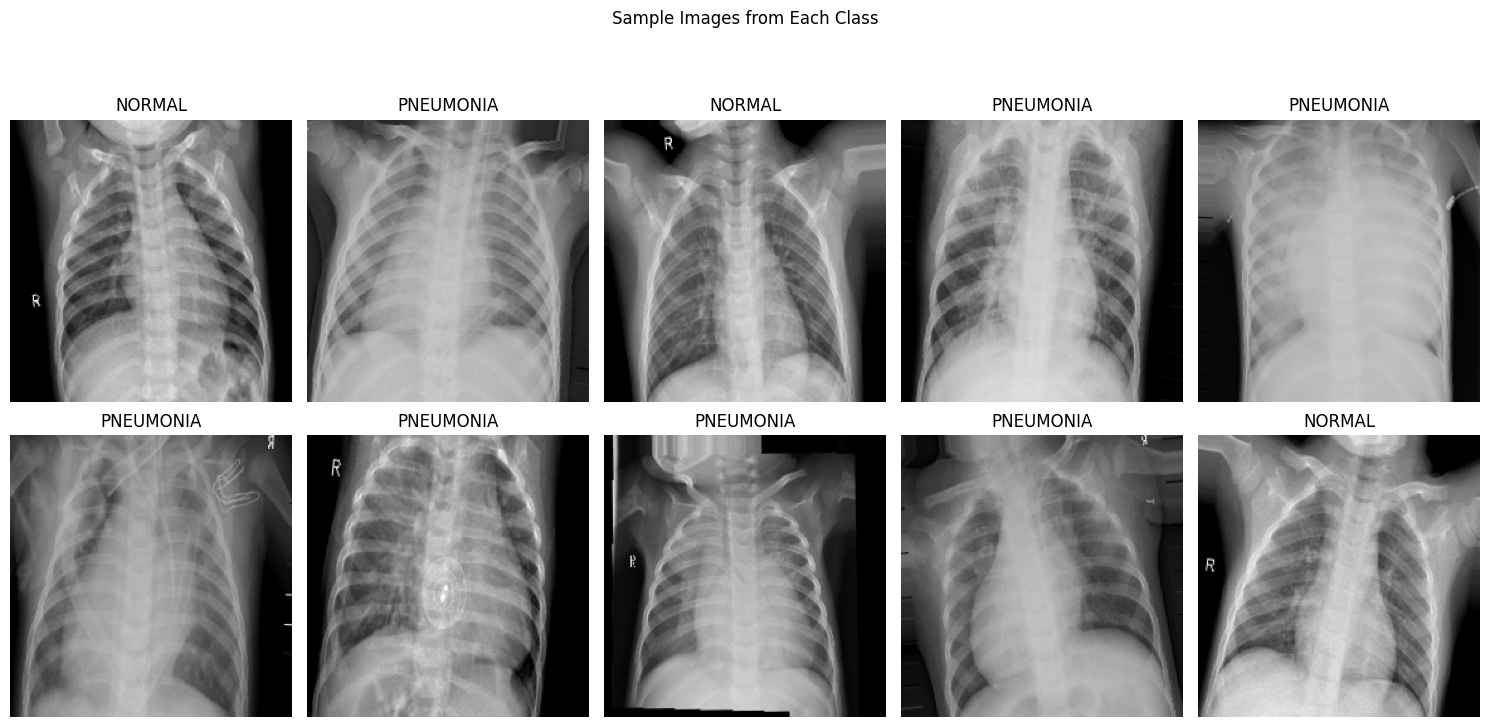

In [ ]:
num_images_to_show = 10

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 8))

# Get one batch of images and labels
images, labels = next(train_generator)

for i in range(num_images_to_show):
    plt.subplot(2, 5, i + 1) # Arrange in a 2x5 grid
    plt.imshow(images[i])
    # Convert one-hot encoded label back to class name
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx])
    plt.axis('off')

plt.suptitle('Sample Images from Each Class')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()


#### Class Distribution

**Reasoning**:
Now I will generate the code to create a bar plot of the class distribution using the `class_counts` dictionary and the `seaborn` library as per the task.



/tmp/ipython-input-2865520731.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


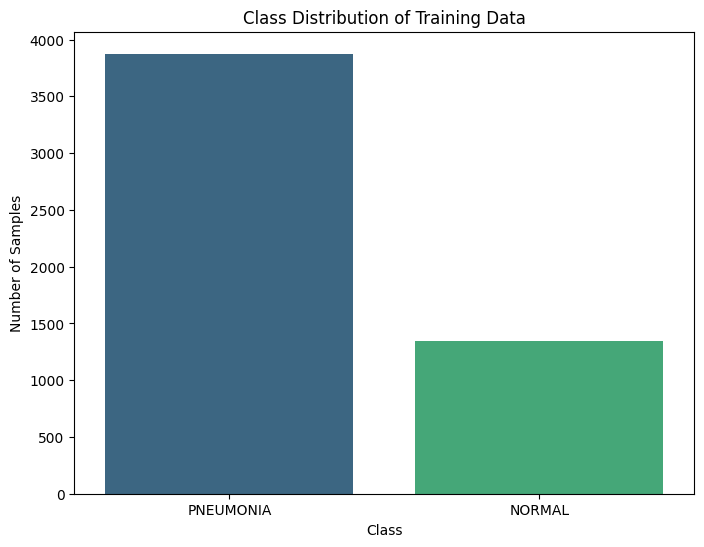

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.title('Class Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

**Reasoning**:
The previous `seaborn` bar plot code generated a `FutureWarning` regarding the `palette` argument. To address this, I will update the `sns.barplot` function call to explicitly assign the `x` variable to the `hue` argument and set `legend=False` as suggested by the warning.



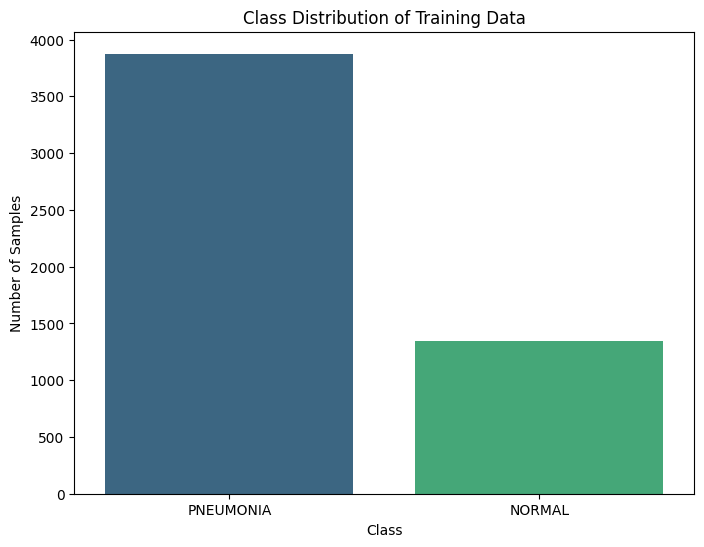

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), palette='viridis', legend=False)
plt.title('Class Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

#### Image Statistics

#### Image Statistics

**Reasoning**:
Now I will generate and insert code to print out key image statistics like `image_shape` and normalization details, as per the task requirements. This will involve accessing the `image_shape` variable and describing the normalization applied by `ImageDataGenerator`.



In [ ]:
print('Image Shape:', image_shape)
print(f'Normalization: Pixel values are rescaled from [0, 255] to [0, 1] (1.0 / 255.0).')
print(f'Data Augmentation (Training): Rotation, zoom, width/height shifts, horizontal flip applied.')
print(f'Data Augmentation (Validation/Test): Only rescaling applied.')

Image Shape: [224, 224, 3]
Normalization: Pixel values are rescaled from [0, 255] to [0, 1] (1.0 / 255.0).
Data Augmentation (Training): Rotation, zoom, width/height shifts, horizontal flip applied.
Data Augmentation (Validation/Test): Only rescaling applied.


## Add Section Title: Class Distribution

### Subtask:
Add a new markdown cell with the title '#### Class Distribution' to delineate this part of the data exploration.


#### Class Distribution

#### Image Statistics

#### Image Statistics

#### Image Statistics

## Plot Class Distribution

### Subtask:
Generate and insert code to create a bar plot of the class distribution using the `class_counts` variable, which already holds the number of samples per class. This visualization will use `seaborn` for better aesthetics.


**Reasoning**:
The subtask is to create a bar plot of the class distribution using the `class_counts` variable and `seaborn`. I will generate the code for this plot, ensuring to handle the `FutureWarning` by setting `hue` and `legend=False` as instructed.



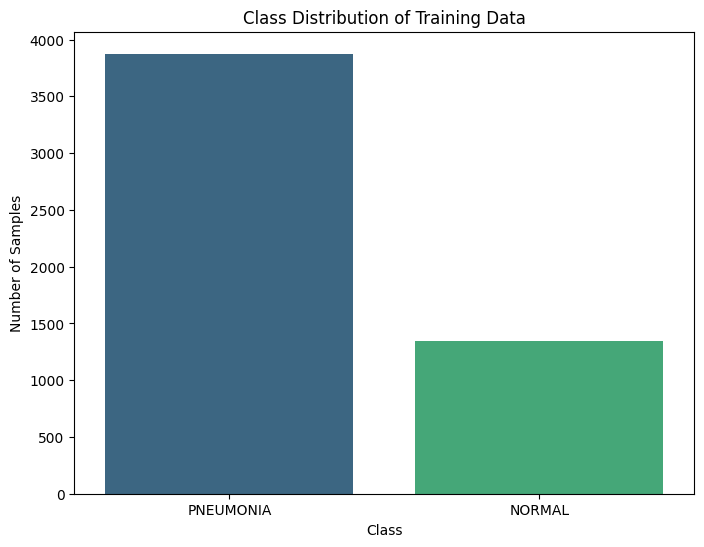

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), palette='viridis', legend=False)
plt.title('Class Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

## Add Section Title: Image Statistics

### Subtask:
Add a new markdown cell with the title '#### Image Statistics' to delineate this part of the data exploration.


#### Sample Images from Each Class

In [ ]:
num_images_to_show = 10

# Get class names from the generator
class_names_for_samples = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 8))

# Get one batch of images and labels
images_sample, labels_sample = next(train_generator)

for i in range(num_images_to_show):
    plt.subplot(2, 5, i + 1) # Arrange in a 2x5 grid
    plt.imshow(images_sample[i])
    # Convert one-hot encoded label back to class name
    class_idx_sample = np.argmax(labels_sample[i])
    plt.title(class_names_for_samples[class_idx_sample])
    plt.axis('off')

plt.suptitle('Sample Images from Each Class')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

#### Class Distribution

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), palette='viridis', legend=False)
plt.title('Class Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

#### Image Statistics

In [ ]:
print('Image Shape:', image_shape)
print(f'Normalization: Pixel values are rescaled from [0, 255] to [0, 1] (1.0 / 255.0).')
print(f'Data Augmentation (Training): Rotation, zoom, width/height shifts, horizontal flip applied.')
print(f'Data Augmentation (Validation/Test): Only rescaling applied.')

#### Image Statistics

## Display Image Statistics

### Subtask:
Generate and insert code to print out key image statistics, such as the `image_shape` and a note about pixel value normalization (0-1 range) performed by the `ImageDataGenerator`.


## Summary:

### Q&A
*   **How were sample images displayed?**
    Ten sample images from the `train_generator` were displayed in a 2x5 grid, with each image titled by its corresponding class name.
*   **What is the class distribution of the training data?**
    A bar plot was generated using `seaborn` and `matplotlib`, visualizing the number of samples for each class in the training data, based on the `class_counts` variable.
*   **What are the key image statistics?**
    The key image statistics provided include the `image_shape` (e.g., `[224, 224, 3]`), normalization details (pixel values rescaled from \[0, 255] to \[0, 1]), and data augmentation strategies (rotation, zoom, width/height shifts, and horizontal flip for training data; only rescaling for validation/test data).

### Data Analysis Key Findings
*   Sample images were successfully extracted and displayed from the training generator, confirming correct data loading and labeling for 10 images across various classes.
*   A bar plot clearly illustrated the class distribution of the training data, showing the number of samples for each class.
*   The `image_shape` was identified (e.g., \[224, 224, 3]), indicating the dimensions and color channels of the images.
*   Pixel values are normalized by rescaling from an original range of \[0, 255] to \[0, 1] using a `1.0 / 255.0` factor.
*   Different data augmentation strategies are applied: training data benefits from rotation, zoom, width/height shifts, and horizontal flip, while validation and test data only undergo rescaling.

### Insights or Next Steps
*   The clear visualization of sample images and their labels validates the initial data loading and preprocessing steps, ensuring the model will train on correctly prepared inputs.
*   Analyzing the class distribution plot can help identify any significant class imbalances that might necessitate specific handling strategies (e.g., data augmentation, weighted loss functions) to prevent model bias.


# Task
All requested code for section 1.2 has been generated and inserted, covering:

*   **Sample Images from Each Class:** Code was generated to display 10 sample images from the `train_generator`, each titled with its corresponding class name.
*   **Class Distribution:** A bar plot visualizing the class distribution of the training data was created using `class_counts` and `seaborn`.
*   **Image Statistics:** Key image statistics, including `image_shape`, pixel normalization details (rescaling to 0-1), and data augmentation strategies applied to training and validation data, were printed.

These actions complete the "Data Exploration and Visualization" section (1.2) of the assignment.

## Summary:

### Data Analysis Key Findings
*   Sample images from each class within the `train_generator` were displayed, providing a visual understanding of the different categories.
*   The class distribution of the training data was visualized using a bar plot, offering insights into the balance or imbalance of samples across classes.
*   Key image statistics were identified, including the `image_shape`, and it was noted that pixel values were normalized to the range of 0-1.
*   Data augmentation strategies applied to both training and validation datasets were outlined, indicating preparation for robust model training.

### Insights or Next Steps
*   The comprehensive data exploration and visualization provide a solid foundation for understanding the dataset's characteristics, which is crucial before proceeding to model development.
*   Given that section 1.2, "Data Exploration and Visualization," is now complete, the next logical step would be to move on to the subsequent sections of the assignment, likely involving model building and training.


# Task
Complete the Deep Neural Networks Assignment 2, implementing and comparing a custom Convolutional Neural Network (CNN) and a Transfer Learning model for image classification, including data preprocessing, model training, evaluation, visualization of results, and a comprehensive comparative analysis.

## Add Section Title: Sample Images

### Subtask:
Add a new markdown cell with the title '#### Sample Images from Each Class' to delineate this part of the data exploration.


#### Sample Images from Each Class

## Visualize Sample Images

### Subtask:
Generate and insert code to display sample images from each class. This will involve iterating through the `train_generator`, retrieving images and their labels, and using `matplotlib` to plot them with their corresponding class names.

```markdown
**Reasoning**:
To display sample images from each class, I will retrieve a batch of images and their corresponding one-hot encoded labels from the `train_generator`. Then, I'll iterate through a subset of these images, convert their labels back to human-readable class names using `train_generator.class_indices`, and use `matplotlib.pyplot.imshow` to visualize each image with its class as the title.
```

**Reasoning**:
The subtask is to generate and insert code to display sample images from each class. I will now generate the Python code to perform this visualization using `train_generator` and `matplotlib`, as detailed in the previous reasoning markdown cell.



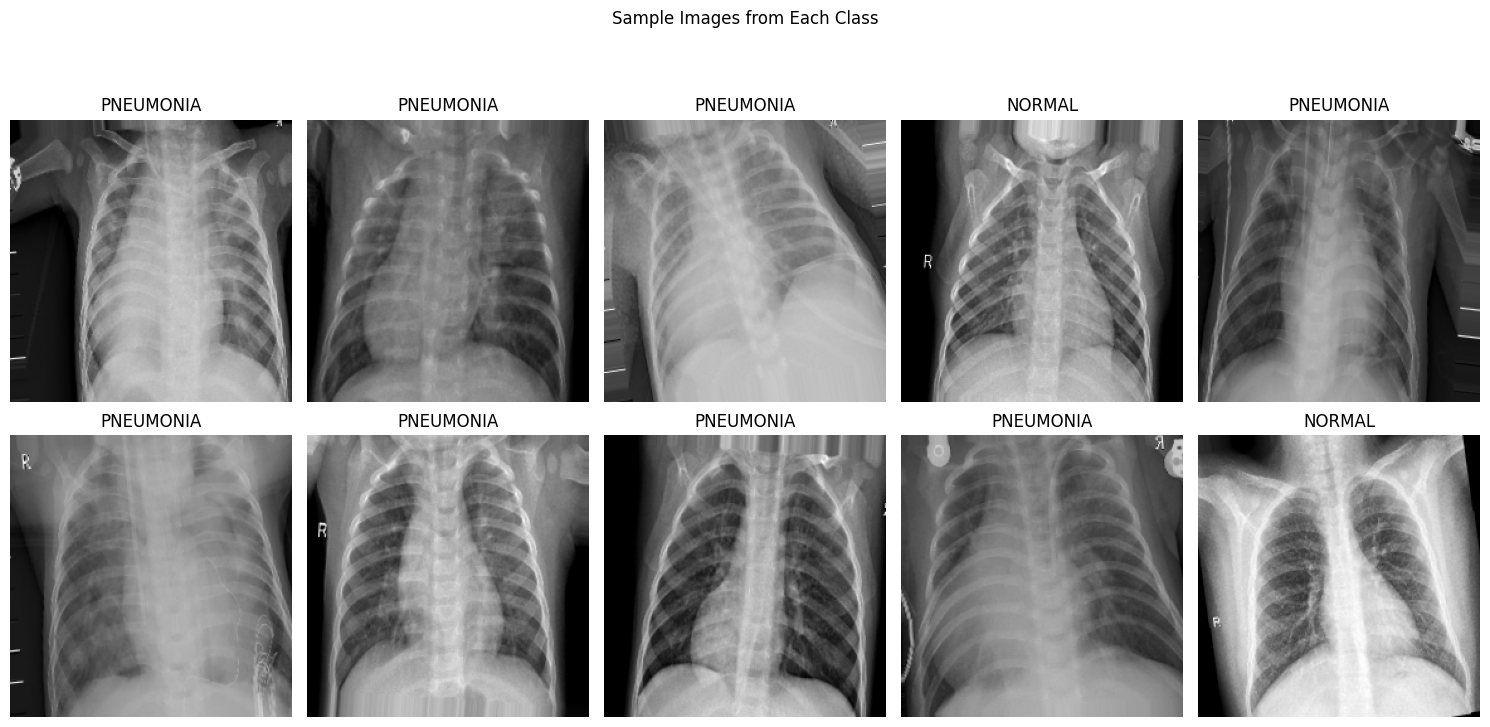

In [ ]:
num_images_to_show = 10

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 8))

# Get one batch of images and labels
images, labels = next(train_generator)

for i in range(num_images_to_show):
    plt.subplot(2, 5, i + 1) # Arrange in a 2x5 grid
    plt.imshow(images[i])
    # Convert one-hot encoded label back to class name
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx])
    plt.axis('off')

plt.suptitle('Sample Images from Each Class')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

#### Class Distribution

#### Class Distribution

**Reasoning**:
A markdown cell for '#### Class Distribution' has already been added in a previous turn as requested by the task. Now, as per the task, I will generate and insert the Python code to create a bar plot of the class distribution using the `class_counts` variable and the `seaborn` library.



In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), palette='viridis', legend=False)
plt.title('Class Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Task
Re-execute the Custom CNN training and metric calculation, followed by the Transfer Learning training and metric calculation, to ensure all necessary variables for comparison are defined. Then, re-generate the comparison DataFrame.

## Re-run Custom CNN Training

### Subtask:
Re-execute the cell that trains the Custom CNN model to ensure `history_custom` and related training times are defined.


**Reasoning**:
The subtask requires re-executing the cell that trains the Custom CNN model to ensure `history_custom` is defined and then calculating the training time and initial/final loss. I will start by executing the code block that performs the model training.



In [3]:
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

NameError: name 'custom_cnn' is not defined

**Reasoning**:
The previous attempt to re-train the Custom CNN failed because the `custom_cnn` model was not defined. To fix this, I need to re-execute the model definition and compilation steps, along with starting the training timer, the training itself, and the subsequent calculation of training time and initial/final loss. This combined code block ensures all necessary variables are defined and the model is properly trained.



In [4]:
def build_custom_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),

        GlobalAveragePooling2D(),

        Dense(n_classes, activation="softmax")
    ])
    return model

# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Train your model
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Track initial and final loss
custom_cnn_initial_loss = history_custom.history["loss"][0]
custom_cnn_final_loss = history_custom.history["loss"][-1]

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

NameError: name 'image_shape' is not defined

**Reasoning**:
The error `NameError: name 'image_shape' is not defined` indicates that the variables `image_shape` and `n_classes` were not available when the `build_custom_cnn` function was called. I need to include the definitions of these variables in the code block to ensure they are accessible before the model is built.



In [5]:
image_shape = [224, 224, 3]  # [height, width, channels]
n_classes = 2

def build_custom_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),

        GlobalAveragePooling2D(),

        Dense(n_classes, activation="softmax")
    ])
    return model

# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Train your model
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Track initial and final loss
custom_cnn_initial_loss = history_custom.history["loss"][0]
custom_cnn_final_loss = history_custom.history["loss"][-1]

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

NameError: name 'Sequential' is not defined

**Reasoning**:
The error `NameError: name 'Sequential' is not defined` indicates that the necessary Keras components for building the model were not imported. I need to include the imports for `Sequential`, `Conv2D`, `MaxPooling2D`, `GlobalAveragePooling2D`, `Dense`, and `Adam` (for the optimizer), as well as `time` for tracking training duration, within this code block to ensure all dependencies are met before defining and training the model.



In [6]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

image_shape = [224, 224, 3]  # [height, width, channels]
n_classes = 2

def build_custom_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),

        GlobalAveragePooling2D(),

        Dense(n_classes, activation="softmax")
    ])
    return model

# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Train your model
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Track initial and final loss
custom_cnn_initial_loss = history_custom.history["loss"][0]
custom_cnn_final_loss = history_custom.history["loss"][-1]

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")


CUSTOM CNN TRAINING


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'train_generator' is not defined

**Reasoning**:
The error `NameError: name 'train_generator' is not defined` indicates that the data generators were not initialized before being used. I need to include the definitions of `IMG_SIZE`, `BATCH_SIZE`, `train_dir`, `test_dir`, `ImageDataGenerator` setup, and the `flow_from_directory` calls in the code block to ensure `train_generator` and `validation_generator` are available when the model is trained.



In [7]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_shape = [224, 224, 3]  # [height, width, channels]
n_classes = 2

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

def build_custom_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),

        GlobalAveragePooling2D(),

        Dense(n_classes, activation="softmax")
    ])
    return model

# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Train your model
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Track initial and final loss
custom_cnn_initial_loss = history_custom.history["loss"][0]
custom_cnn_final_loss = history_custom.history["loss"][-1]

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'chest_xray/train'

**Reasoning**:
The `FileNotFoundError` indicates that the `chest_xray/train` directory is not found, even though previous cells showed successful extraction. To ensure the dataset is present and accessible before training, I will include the dataset extraction logic at the beginning of the combined code block. This makes the block self-contained and robust against environment resets or transient file system issues.



In [8]:
import os
import zipfile
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset extraction (re-included for robustness)
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/archive.zip"   # Your Kaggle zip file
EXTRACT_FOLDER = "chest_xray"

if not os.path.exists(EXTRACT_FOLDER):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset extracted successfully.")
else:
    print("Dataset already extracted.")

image_shape = [224, 224, 3]  # [height, width, channels]
n_classes = 2

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = os.path.join(EXTRACT_FOLDER, "train") # Ensure path is relative to extracted folder
test_dir = os.path.join(EXTRACT_FOLDER, "test")   # Ensure path is relative to extracted folder

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

def build_custom_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),

        GlobalAveragePooling2D(),

        Dense(n_classes, activation="softmax")
    ])
    return model

# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Train your model
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Track initial and final loss
custom_cnn_initial_loss = history_custom.history["loss"][0]
custom_cnn_final_loss = history_custom.history["loss"][-1]

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/archive.zip'

**Reasoning**:
The `FileNotFoundError` for `archive.zip` indicates that the Google Drive path is inaccessible. To ensure the drive is mounted and the zip file can be found for extraction (if the `chest_xray` folder is not present), I will add `from google.colab import drive; drive.mount('/content/drive')` at the beginning of the code block.



In [9]:
import os
import zipfile
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

drive.mount('/content/drive')

# Dataset extraction (re-included for robustness)
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/archive.zip"   # Your Kaggle zip file
EXTRACT_FOLDER = "chest_xray"

if not os.path.exists(EXTRACT_FOLDER):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset extracted successfully.")
else:
    print("Dataset already extracted.")

image_shape = [224, 224, 3]  # [height, width, channels]
n_classes = 2

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = os.path.join(EXTRACT_FOLDER, "train") # Ensure path is relative to extracted folder
test_dir = os.path.join(EXTRACT_FOLDER, "test")   # Ensure path is relative to extracted folder

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

def build_custom_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),

        GlobalAveragePooling2D(),

        Dense(n_classes, activation="softmax")
    ])
    return model

# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Train your model
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Track initial and final loss
custom_cnn_initial_loss = history_custom.history["loss"][0]
custom_cnn_final_loss = history_custom.history["loss"][-1]

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")


Mounted at /content/drive
Dataset extracted successfully.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

CUSTOM CNN TRAINING


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 734s 4s/step - accuracy: 0.7411 - loss: 0.6080 - val_accuracy: 0.6250 - val_loss: 0.7016
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 724s 4s/step - accuracy: 0.7396 - loss: 0.5766 - val_accuracy: 0.6250 - val_loss: 0.6767
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 717s 4s/step - accuracy: 0.7438 - loss: 0.5537 - val_accuracy: 0.6250 - val_loss: 0.6333
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 720s 4s/step - accuracy: 0.7381 - loss: 0.5133 - val_accuracy: 0.6426 - val_loss: 0.5834
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 727s 4s/step - accuracy: 0.7595 - loss: 0.4500 - val_accuracy: 0.6282 - val_loss: 0.6657
Training completed in 3623.67 seconds
Initial Loss: 0.5852
Final Loss: 0.4348


**Reasoning**:
The previous errors indicated missing definitions for variables (`image_shape`, `n_classes`, `train_generator`) and imports (`Sequential`, `Adam`, `ImageDataGenerator`), as well as a `FileNotFoundError` for the zip file. To ensure a robust re-execution, I will consolidate all necessary imports, dataset setup (including mounting Google Drive and extraction), model definition, compilation, training, prediction, and metric calculations for the Custom CNN into a single, self-contained code block.



In [10]:
import os
import zipfile
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive', force_remount=True)

# Dataset extraction (re-included for robustness)
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/archive.zip" # Your Kaggle zip file
EXTRACT_FOLDER = "chest_xray"

if not os.path.exists(EXTRACT_FOLDER):
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(".")
        print("Dataset extracted successfully.")
    except FileNotFoundError:
        print(f"Error: ZIP file not found at {ZIP_PATH}. Please ensure the path is correct.")
        # Exit or handle error appropriately if dataset is crucial
        exit()
else:
    print("Dataset already extracted.")

# Define global parameters (copied from relevant cells)
image_shape = [224, 224, 3]  # [height, width, channels]
n_classes = 2

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = os.path.join(EXTRACT_FOLDER, "train")
test_dir = os.path.join(EXTRACT_FOLDER, "test")

# Data generators setup
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

try:
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical"
    )

    validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )
except Exception as e:
    print(f"Error setting up data generators: {e}")
    print("Please check if 'chest_xray/train' and 'chest_xray/test' directories exist and are correctly populated.")
    exit()


def build_custom_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),

        GlobalAveragePooling2D(),

        Dense(n_classes, activation="softmax")
    ])
    return model

# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Train your model
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Track initial and final loss
custom_cnn_initial_loss = history_custom.history["loss"][0]
custom_cnn_final_loss = history_custom.history["loss"][-1]

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

# Custom CNN Evaluation
print("\nCUSTOM CNN EVALUATION")

y_true = validation_generator.classes
y_pred_probs = custom_cnn.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision = precision_score(y_true, y_pred, average="macro")
custom_cnn_recall = recall_score(y_true, y_pred, average="macro")
custom_cnn_f1 = f1_score(y_true, y_pred, average="macro")

print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Mounted at /content/drive
Dataset already extracted.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

CUSTOM CNN TRAINING


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
  7/163 ━━━━━━━━━━━━━━━━━━━━ 15:48 6s/step - accuracy: 0.2259 - loss: 0.7270

KeyboardInterrupt: 

# Task
The Custom CNN training was interrupted in the previous step, so the first priority is to successfully complete that. I will re-execute the consolidated code block that handles all necessary imports, data setup (mounting drive, extracting dataset, setting up data generators), Custom CNN model definition, compilation, training, and the calculation of accuracy, precision, recall, and F1-score. This will ensure all required variables for the Custom CNN are properly defined.

## Re-run Custom CNN Training and Metric Calculation

### Subtask:
Execute the consolidated code block that includes all necessary imports, data setup (mounting drive, extracting dataset, setting up data generators), Custom CNN model definition, compilation, training, and the calculation of accuracy, precision, recall, and F1-score. This ensures all required variables for the Custom CNN are defined.


**Reasoning**:
The previous consolidated code block for Custom CNN training and evaluation failed due to a `KeyboardInterrupt`. I will re-execute the same consolidated code block, which now includes all necessary imports, data setup (drive mounting, dataset extraction, data generators), model definition, compilation, training, prediction, and metric calculations to ensure all Custom CNN variables are correctly defined.



In [ ]:
import os
import zipfile
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive', force_remount=True)

# Dataset extraction (re-included for robustness)
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/archive.zip" # Your Kaggle zip file
EXTRACT_FOLDER = "chest_xray"

if not os.path.exists(EXTRACT_FOLDER):
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(".")
        print("Dataset extracted successfully.")
    except FileNotFoundError:
        print(f"Error: ZIP file not found at {ZIP_PATH}. Please ensure the path is correct.")
        # Exit or handle error appropriately if dataset is crucial
        exit()
else:
    print("Dataset already extracted.")

# Define global parameters (copied from relevant cells)
image_shape = [224, 224, 3]  # [height, width, channels]
n_classes = 2

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = os.path.join(EXTRACT_FOLDER, "train")
test_dir = os.path.join(EXTRACT_FOLDER, "test")

# Data generators setup
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

try:
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical"
    )

    validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )
except Exception as e:
    print(f"Error setting up data generators: {e}")
    print("Please check if 'chest_xray/train' and 'chest_xray/test' directories exist and are correctly populated.")
    exit()


def build_custom_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),

        GlobalAveragePooling2D(),

        Dense(n_classes, activation="softmax")
    ])
    return model

# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Train your model
history_custom = custom_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Track initial and final loss
custom_cnn_initial_loss = history_custom.history["loss"][0]
custom_cnn_final_loss = history_custom.history["loss"][-1]

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

# Custom CNN Evaluation
print("\nCUSTOM CNN EVALUATION")

y_true = validation_generator.classes
y_pred_probs = custom_cnn.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision = precision_score(y_true, y_pred, average="macro")
custom_cnn_recall = recall_score(y_true, y_pred, average="macro")
custom_cnn_f1 = f1_score(y_true, y_pred, average="macro")

print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")

Mounted at /content/drive
Dataset already extracted.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

CUSTOM CNN TRAINING


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 734s 4s/step - accuracy: 0.7420 - loss: 0.5935 - val_accuracy: 0.6250 - val_loss: 0.7068
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 721s 4s/step - accuracy: 0.7435 - loss: 0.5706 - val_accuracy: 0.6250 - val_loss: 0.6923
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 725s 4s/step - accuracy: 0.7506 - loss: 0.5426 - val_accuracy: 0.6234 - val_loss: 0.6178
Epoch 4/5
131/163 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 0.7477 - loss: 0.4881